In [1]:
import os
import pandas as pd

In [ ]:
FILTER_SDATA = True

In [2]:
fjssp_path = r'C:\Users\huda\Downloads\paper_results\paper_results\fjssp\\'

In [3]:
cp_path_fjssp = fjssp_path + 'results_cplex_cp.txt'
ortools_path_fjssp = fjssp_path + 'results_ortools.txt'
gurobi_path_fjssp = fjssp_path + 'results_gurobi.txt'
cplp_path_fjssp = fjssp_path + 'results_cplex_lp.txt'
hexaly_path_fjssp = fjssp_path + 'results_hexaly.txt'
ga_best_path_fjssp = fjssp_path + 'ga_best.txt'
ga_average_path_fjssp = fjssp_path + 'ga_average.txt'

In [4]:
fjssp_w_path = r'C:\Users\huda\Downloads\paper_results\paper_results\fjssp-w\\'

In [5]:
cp_path_fjssp_w = fjssp_w_path + 'results_cplex_cp.txt'
ortools_path_fjssp_w = fjssp_w_path + 'results_ortools.txt'
gurobi_path_fjssp_w = fjssp_w_path + 'results_gurobi.txt'
cplp_path_fjssp_w = fjssp_w_path + 'results_cplex_lp.txt'
hexaly_path_fjssp_w = fjssp_w_path + 'results_hexaly.txt'
ga_best_path_fjssp_w = fjssp_w_path + 'ga_best.txt'
ga_average_path_fjssp_w = fjssp_w_path + 'ga_average.txt'

In [6]:
def read_file(file : str, worker : bool = True) -> pd.DataFrame:
    if worker:
        file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    else:#
        file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    del file_content
    if worker:
        df = df.drop(columns=['result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram'])
    else:
        df = df.drop(columns=['result_vector1', 'result_vector2', 'peak_cpu', 'peak_ram'])
    df = df[~df['name'].str.startswith('Error')]
    df = df[df['fitness_value'] != float('inf')]
    return df

In [7]:
cp_fjssp = read_file(cp_path_fjssp, False)
cp_fjssp_w = read_file(cp_path_fjssp_w)

In [8]:
cplp_fjssp = read_file(cplp_path_fjssp, False)
cplp_fjssp_w = read_file(cplp_path_fjssp_w)

In [9]:
gurobi_fjssp = read_file(gurobi_path_fjssp, False)
gurobi_fjssp_w = read_file(gurobi_path_fjssp_w)

In [10]:
ortools_fjssp = read_file(ortools_path_fjssp, False)
ortools_fjssp_w = read_file(ortools_path_fjssp_w)

In [11]:
hexaly_fjssp = read_file(hexaly_path_fjssp, False)
hexaly_fjssp_w = read_file(hexaly_path_fjssp_w)

In [12]:
ga_best_fjssp = read_file(ga_best_path_fjssp, False)
ga_best_fjssp_w = read_file(ga_best_path_fjssp_w)

In [13]:
ga_average_fjssp = read_file(ga_average_path_fjssp, False)
ga_average_fjssp_w = read_file(ga_average_path_fjssp_w)

In [14]:
solver = dict()
solver['cplex_cp'] = dict()
solver['ortools'] = dict()
solver['ga_best'] = dict()
solver['ga_average'] = dict()
solver['gurobi'] = dict()
solver['cplex_lp'] = dict()
solver['hexaly'] = dict()

In [15]:
def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[0].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[0].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[0].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('r'):
        return 'HurinkRdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[0].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[0].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[0].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

In [18]:
def setup_dict():
    compare = dict()
    compare['worker'] = dict()
    compare['no_worker'] = dict()
    return compare

In [ ]:
def change_name(name):
    full = name.split('_')
    if len(full) > 1:
        name = ''.join(full[1:-1]).lower()
    else:
        name = full[0].lower()
    if name.endswith('.fjs'):
        name = name[:-4]
    if name.startswith('behnkegeiger'):
        name = name.replace('geiger', '')
    if name.startswith('brand') and 'mk' in name:
        name = name.replace('mk', '')
    return name

def get_last(history):
    data = history.split('(')
    result = float(data[-1][:-2].split(', ')[0])
    return result

def extract_time_to_best(instances):
    result = dict()
    #NOTE: does not work for hexaly
    for index, row in instances.iterrows():
        history = row['best_result_history']
        result[change_name(row['name'])] = get_last(history)
    return result

def extract_n_improvements(instances):
    result = dict()
    for index, row in instances.iterrows():
        history = row['best_result_history']
        count = 0
        if not '<docplex' in history:
            history_list = eval(history.replace('inf', 'float("inf")'))
            last = history_list[0][1]
            count = 1
            for i in range(1, len(history_list)):
                if history_list[i][1] != last:
                    last = history_list[i][1]
                    count += 1
        result[change_name(row['name'])] = count
    return result

def extract_solver_data(fjssp, fjssp_w):
    compare = setup_dict()
    time_to_best = extract_time_to_best(fjssp)
    n_improvements = extract_n_improvements(fjssp)
    for index, row in fjssp.iterrows():
        name = change_name(row['name'])
        compare['no_worker'][name] = {
            'fitness': row['fitness_value'],
            'lower_bound': row['lower_bound'],
            'status': row['optimization_status'],
            'runtime': row['runtime'],
            'time_to_best': time_to_best[name],
            'n_improvements': n_improvements[name] # TODO: test
        }
    time_to_best = extract_time_to_best(fjssp_w)
    n_improvements = extract_n_improvements(fjssp_w)
    for index, row in fjssp_w.iterrows():
        name = change_name(row['name'])
        if FILTER_SDATA and 'sdata' in name:
            continue
        #name = row['name']#remap(row['name'][2:-12])
        #if name in compare['no_worker']:
        compare['worker'][name] = {
            'fitness': row['fitness_value'],
            'lower_bound': row['lower_bound'],
            'status': row['optimization_status'],
            'runtime': row['runtime'],
            'time_to_best': time_to_best[name],
            'n_improvements': n_improvements[name] # TODO: test
        }
    return compare

In [84]:
solver['cplex_cp'] = extract_solver_data(cp_fjssp, cp_fjssp_w)
solver['cplex_lp'] = extract_solver_data(cplp_fjssp, cplp_fjssp_w)
solver['gurobi'] = extract_solver_data(gurobi_fjssp, gurobi_fjssp_w)
solver['ortools'] = extract_solver_data(ortools_fjssp, ortools_fjssp_w)
solver['ga_best'] = extract_solver_data(ga_best_fjssp, ga_best_fjssp_w)
solver['ga_average'] = extract_solver_data(ga_average_fjssp, ga_average_fjssp_w)
solver['hexaly'] = extract_solver_data(hexaly_fjssp, hexaly_fjssp_w)

In [85]:
for s in solver:
    print(f'{s}: {len(solver[s]["no_worker"])} | {len(solver[s]["worker"])}')

cplex_cp: 400 | 402
ortools: 402 | 397
ga_best: 402 | 402
ga_average: 402 | 402
gurobi: 402 | 320
cplex_lp: 402 | 321
hexaly: 0 | 402


In [86]:
for instance in solver['cplex_cp']['worker']:
    if instance.startswith('Brand'):
        print(instance)

In [87]:
for s in solver:
    print(s+':')
    for instance in solver[s]['no_worker']:
        if instance not in solver[s]['worker']:
            print(instance)

cplex_cp:
ortools:
behnke56
behnke57
behnke58
behnke59
behnke60
ga_best:
ga_average:
gurobi:
behnke11
behnke12
behnke13
behnke14
behnke15
behnke16
behnke17
behnke18
behnke19
behnke20
behnke21
behnke22
behnke23
behnke24
behnke25
behnke26
behnke27
behnke28
behnke29
behnke30
behnke31
behnke32
behnke33
behnke34
behnke35
behnke36
behnke37
behnke38
behnke39
behnke40
behnke41
behnke42
behnke43
behnke44
behnke45
behnke46
behnke47
behnke48
behnke49
behnke5
behnke50
behnke51
behnke52
behnke53
behnke54
behnke55
behnke56
behnke57
behnke58
behnke59
behnke6
behnke60
behnke7
behnke8
behnke9
brandimarte10
brandimarte13
brandimarte15
hurinkvdata27
hurinkvdata29
hurinkvdata30
hurinkvdata31
hurinkvdata32
hurinkvdata33
hurinkvdata34
hurinkvdata35
hurinkvdata36
hurinkvdata37
hurinkvdata38
hurinkvdata39
hurinkvdata40
hurinkvdata41
hurinkvdata42
hurinkvdata43
hurinkvdata46
hurinkvdata47
hurinkvdata48
dppaulli12
dppaulli15
dppaulli17
dppaulli18
dppaulli9
cplex_lp:
behnke1
behnke10
behnke11
behnke12
behnke13
b

In [119]:
def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs

def get_max_w(durations):
    max = 0
    for operation in durations:
        for machine in operation:
            for worker in machine:
                if worker > max:
                    max = worker
    return max

def get_max(durations):
    max = 0
    for operation in durations:
        for machine in operation:
        
            if machine > max:
                max = machine
    return max

def worker_flexibility(benchmark):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    combs = dict()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    n_assignments += 1
                combs[(j,k)] = 1
    average_assignments = n_assignments / o
    return average_assignments / len(combs)

def flexibility(benchmark):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                n_assignments += 1
    average_assignments = n_assignments / o
    return average_assignments / n_assignments

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
                    all += 1
            if any([x > 0 for x in durations[i][j]]):
                machines_available+=1
    return worker_flexibility(benchmark), len(unique) / all

def get_flexibility_and_dv(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                if durations[i][j] not in unique:
                    unique.append(durations[i][j])
                all += 1
        if any([x > 0 for x in durations[i]]):
            machines_available+=1
    return flexibility(benchmark), len(unique) / all

In [120]:
def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev


In [121]:
import statistics
import math
def remap_full(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[1].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[1].startswith('Brandimarte'):
        return 'Brandimarte'+values[-1]
    if values[1].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('r'):
        return 'HurinkRdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[1].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[1].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[1].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name.lower()

from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser, BenchmarkParser
import os
includeWorkers = False
if includeWorkers:
    path = r'C:\Users\huda\Downloads\paper_results\paper_results\benchmarks_with_workers'
    parser = WorkerBenchmarkParser()
else:
    path = r'C:\Users\huda\Downloads\paper_results\paper_results\benchmarks_no_workers'
    parser = BenchmarkParser()
instances = os.listdir(path)
instance_data = dict()
consider_duration_features = True
for instance in instances:
    encoding = parser.parse_benchmark(path + "\\" + instance)
    feature_vector = []
    min_d, max_d, d_span, d_stdev = calculate_duration_features(encoding.durations()) if not includeWorkers else calculate_duration_features_workers(encoding.durations())
    #TODO: worker data, or just do it with base FJSSP since all benchmarks are transformed in the same way
    f, dv = get_flexibility_and_dv(encoding) if not includeWorkers else get_flexibility_and_dv_worker(encoding)
    extracted_data = {
        "name": change_name(instance),
        "n_jobs": encoding.n_jobs(), 
        "n_machines": encoding.n_machines(),
        "n_operations": encoding.n_operations(),
        "durations": encoding.durations(),
        "job_sequence": encoding.job_sequence(),
        "machines_for_all_operations": encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(),
        "flexibility": f,
        "duration_variety": dv,
        "average_operations": calculate_average_operations(encoding.job_sequence()),
        "min_duration": min_d,
        "max_duration": max_d,
        "duration_span": d_span,
        "duration_std": d_stdev
    }
    instance_data[change_name(instance[:-4]) if not includeWorkers else remap_full(instance[:-12])] = extracted_data

In [122]:
instance_data.keys()

dict_keys(['behnke1', 'behnke10', 'behnke11', 'behnke12', 'behnke13', 'behnke14', 'behnke15', 'behnke16', 'behnke17', 'behnke18', 'behnke19', 'behnke2', 'behnke20', 'behnke21', 'behnke22', 'behnke23', 'behnke24', 'behnke25', 'behnke26', 'behnke27', 'behnke28', 'behnke29', 'behnke3', 'behnke30', 'behnke31', 'behnke32', 'behnke33', 'behnke34', 'behnke35', 'behnke36', 'behnke37', 'behnke38', 'behnke39', 'behnke4', 'behnke40', 'behnke41', 'behnke42', 'behnke43', 'behnke44', 'behnke45', 'behnke46', 'behnke47', 'behnke48', 'behnke49', 'behnke5', 'behnke50', 'behnke51', 'behnke52', 'behnke53', 'behnke54', 'behnke55', 'behnke56', 'behnke57', 'behnke58', 'behnke59', 'behnke6', 'behnke60', 'behnke7', 'behnke8', 'behnke9', 'brandimarte1', 'brandimarte10', 'brandimarte11', 'brandimarte12', 'brandimarte13', 'brandimarte14', 'brandimarte15', 'brandimarte2', 'brandimarte3', 'brandimarte4', 'brandimarte5', 'brandimarte6', 'brandimarte7', 'brandimarte8', 'brandimarte9', 'chambersbarnes1', 'chambersbarn

In [123]:
def print_instance(data):
    print(f"# Operations: {data['n_operations']} | # Machines: {data['n_machines']} | Flexibility: {data['flexibility']} | Duration Variety: {data['duration_variety']}")

In [124]:
def get_diff(solver, filter : bool = False, verbose : bool = False):
    diff = []
    o = []
    m = []
    f = []
    dv = []
    for instance in solver['worker']:
        if instance in solver['no_worker']:
            if filter and min(solver["no_worker"][instance]["runtime"], 1200) == min(solver["worker"][instance]["runtime"], 1200):
                continue
            if verbose:
                print(instance)
                print_instance(instance_data[instance])
                print(f'FJSSP Status: {solver["no_worker"][instance]["status"]} | FJSSP-W Status: {solver["worker"][instance]["status"]}')
                print(f'FJSSP Runtime: {solver["no_worker"][instance]["runtime"]} | FJSSP-W Status: {solver["worker"][instance]["runtime"]}')
            diff.append(abs(solver["worker"][instance]["runtime"]-solver["no_worker"][instance]["runtime"]))
            o.append(instance_data[instance]['n_operations'])
            m.append(instance_data[instance]['n_machines'])
            f.append(instance_data[instance]['flexibility'])
            dv.append(instance_data[instance]['duration_variety'])
    return diff, o, m, f, dv

In [125]:
import matplotlib.pyplot as plt
def plot_runtime_difference(diff, o, m, f, dv, filter : bool = False):
    fig = plt.figure(layout='tight', figsize=(15, 8))
    axs = fig.subplots(2, 2)
    fig.suptitle(f'{"(Filtered)" if filter else ""} Benchmark Selection - FJSSP Benchmark Attributes')
    axs[0][0].scatter(diff, o)
    axs[0][0].set_title('Operations')
    axs[0][0].set_xlabel('runtime worker - runtime no worker')
    axs[0][0].set_ylabel('# operations')
    axs[0][1].scatter(diff, m)
    axs[0][1].set_title('Machines')
    axs[0][1].set_xlabel('runtime worker - runtime no worker')
    axs[0][1].set_ylabel('# machines')
    axs[1][0].scatter(diff, f)
    axs[1][0].set_title('Flexibility')
    axs[1][0].set_xlabel('runtime worker - runtime no worker')
    axs[1][0].set_ylabel('flexibility')
    axs[1][1].scatter(diff, dv)
    axs[1][1].set_title('Duration Variety')
    axs[1][1].set_xlabel('runtime worker - runtime no worker')
    axs[1][1].set_ylabel('duration variety')
    plt.show()


In [126]:
diff, o, m, f, dv = get_diff(solver['cplex_cp'], filter=True)

In [153]:
plt.rcParams['axes.grid'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
colors = {
    'cplex_cp': 'blue',
    'ortools': 'slateblue',
    'hexaly': 'mediumvioletred',
    'ga_best': 'forestgreen',
    'ga_average': 'limegreen',
    'gurobi': 'rosybrown',
    'cplex_lp': 'lightcoral',
}
markers = {
    'cplex_cp': '^',
    'ortools': 'v',
    'hexaly': 'x',
    'ga_best': '>',
    'ga_average': '<',
    'gurobi': 'o',
    'cplex_lp': 'p',
}
markerson = 0.1

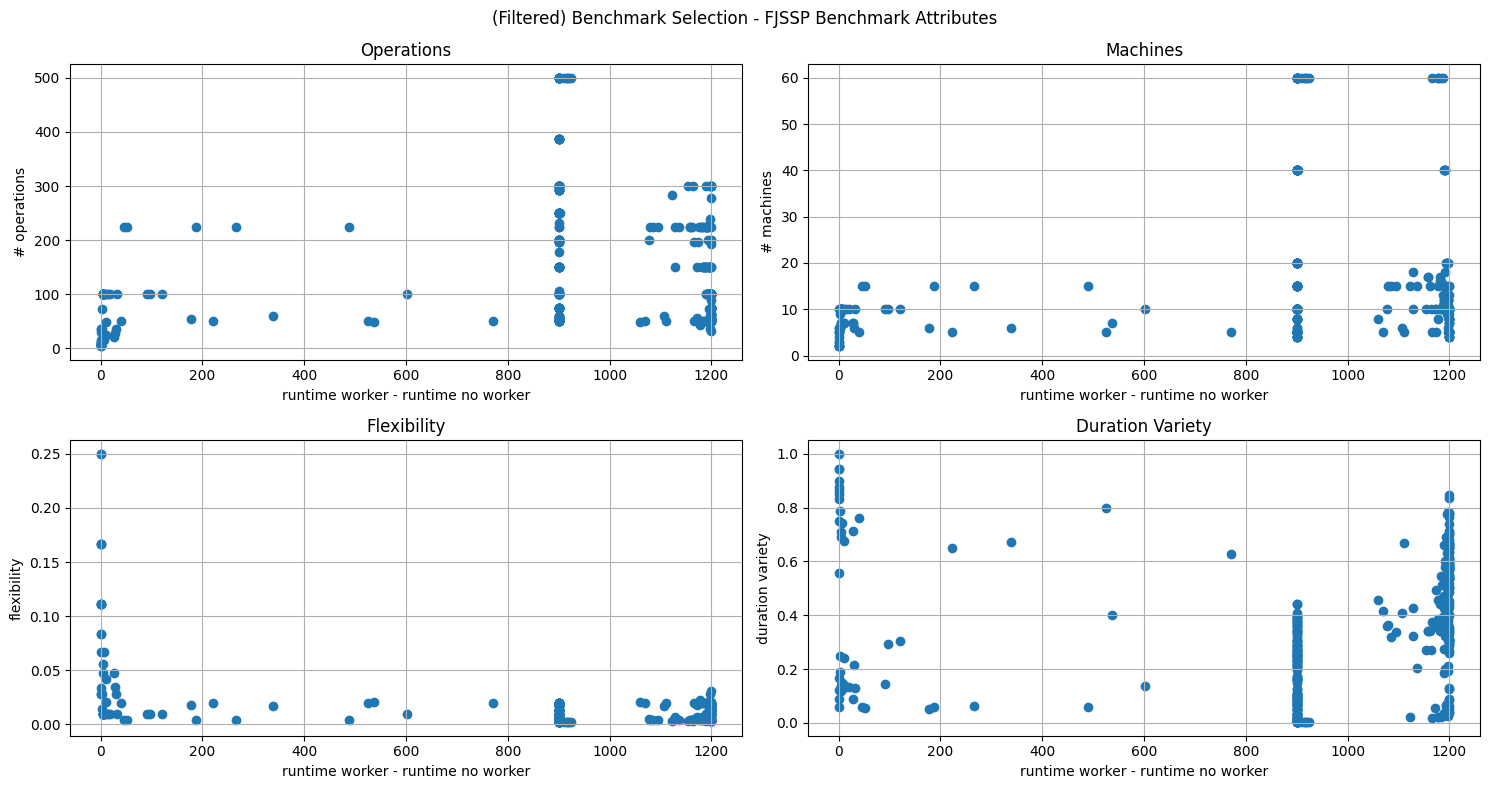

In [131]:
plot_runtime_difference(diff, o, m, f, dv, True)

In [158]:
def get_comparison(data, instance, column, max = False):
    best_fjssp = float('inf')
    best_fjssp_w = float('inf')
    for key in data.keys():
        if instance in data[key]['no_worker']:
            fitness_fjssp = data[key]['no_worker'][instance]['fitness']#optimizer['no_worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp < best_fjssp:
                best_fjssp = fitness_fjssp
        if instance in data[key]['worker']:
            fitness_fjssp_w = data[key]['worker'][instance]['fitness']#optimizer.loc[optimizer['worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp_w < best_fjssp_w:
                best_fjssp_w = fitness_fjssp_w
    return best_fjssp, best_fjssp_w

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_best_fjssp(path = r'C:\Users\huda\Downloads\paper_results\paper_results\fjssp\best_known_20250307.csv'):
    import csv
    result = dict()
    with open(path, 'r') as f:
        csv_data = csv.DictReader(f, delimiter=';')
        for data in csv_data:
            #print(data)
            #print(remap_full(data['Source']+'_'+data['Instance']))
            result[change_name(remap_full(data['Source']+'_'+data['Instance']))] = int(float(data['UB_ges']) + 0.5)
    return result

def get_cdf_comparison_vector(data : dict, column, max, instances, known_best = False, known_path = None):
    results = []
    if known_best:
        if known_path:
            all_best_fjssp = get_best_fjssp(known_path)
        else:
            all_best_fjssp = get_best_fjssp()
    for _ in data:
        results.append([[],[]])
    for instance in instances:
        best_fjssp, best_fjssp_w = get_comparison(data, instance, column, max)
        if known_best:
            best_fjssp = all_best_fjssp[instance]
        i = 0
        for key in data.keys():
            if instance in data[key]['no_worker']:
                results[i][0].append(calculate_value(data[key]['no_worker'][instance]['fitness'], best_fjssp))
            if instance in data[key]['worker']:
                results[i][1].append(calculate_value(data[key]['worker'][instance]['fitness'], best_fjssp_w))
            i += 1
    for result in results:
        result[0].sort()
        result[1].sort()
    return results

In [191]:
def ecdf_inf(data, column = 'fitness_value', max : bool = False, n_instances : int = 30, labels : list[str] = [], instances : list[str] = [], colors : list[str] = [], hlines : list = [], markers : list = [], markerson : list = [], known_best_fjssp = False):
    vectors = get_cdf_comparison_vector(data, column, max, instances, known_best_fjssp)
    plot_vectors = []

    for vector in vectors:
        plot_vectors.append([[[0.0],[0.0]], [[0.0],[0.0]]])
        i = 1
        while i < len(vector[0]):
            if vector[0][i] == float('inf'):
                break
            if vector[0][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0][0].append(vector[0][i-1])
            plot_vectors[-1][0][1].append((i-1)/n_instances)
            i += 1
        i = 1
        while i < len(vector[1]):
            if vector[1][i] == float('inf'):
                break
            if vector[1][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][1][0].append(vector[1][i-1])
            plot_vectors[-1][1][1].append((i-1)/n_instances)
            i += 1
    fig = plt.figure(layout='tight', figsize=(10, 5))
    axs = fig.subplots(1, 2)
    for i in range(len(vectors)):
        axs[0].plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i]], c=colors[labels[i]], linestyle='solid', marker=markers[labels[i]], markevery=markerson)
    axs[0].set_title('FJSSP')
    if not known_best_fjssp:
        axs[0].set_xlim(-0.01, 0.7)
    else:
        axs[0].set_xlim(-0.25, 0.7)
    axs[0].set_xlabel('$\delta_{rel}$')
    axs[0].set_ylabel('Portion of instances $\leq \delta_{rel}$')
    axs[0].axhline(y=hlines[0], alpha=0.7, color='black', linestyle='dotted')#, label='optimal')
    axs[0].legend()
    for i in range(len(vectors)):
        axs[1].plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]], c=colors[labels[i]], marker=markers[labels[i]], markevery=markerson)
    axs[1].axhline(y=hlines[1], alpha=0.7, color='black', linestyle='dotted')#, label='optimal')
    axs[1].set_title('FJSSP-W')
    axs[1].set_xlabel('$\delta_{rel}$')
    axs[1].set_ylabel('Portion of instances $\leq \delta_{rel}$')
    axs[1].set_xlim(-0.01, 0.7)
    axs[1].legend()

    #plt.xlim(-0.1, 1.0)
    plt.legend()
    #plt.title('FJSSP - FJSSP-W')
    plt.show()

In [214]:
optimal_instances = {'no_worker': [], 'worker': []}
for instance in solver['ga_best']['worker']:
    for s in solver:
        #if s == 'cplex_cp' or s == 'ortools':
        if instance in solver[s]['no_worker']:
            if solver[s]['no_worker'][instance]['status'] == 1 and instance not in optimal_instances['no_worker']:
                    optimal_instances['no_worker'].append(instance)
        if instance in solver[s]['worker']:
            if solver[s]['worker'][instance]['status'] == 1 and instance not in optimal_instances['worker']:
                optimal_instances['worker'].append(instance)

In [215]:
h_line_fjssp = len(optimal_instances['no_worker'])/len(solver['ga_best']['worker'])
h_line_fjssp_w = len(optimal_instances['worker'])/len(solver['ga_best']['worker'])

In [216]:
filtered_instances = list(solver['cplex_cp']['worker'].keys())

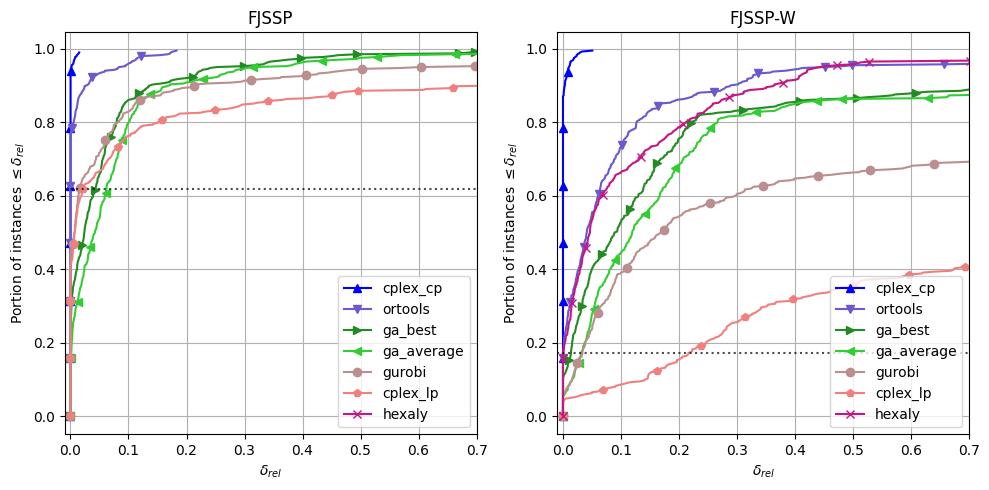

In [217]:
ecdf_inf(solver, instances=filtered_instances, n_instances=len(filtered_instances), labels=list(solver.keys()), colors=colors, hlines=[h_line_fjssp, h_line_fjssp_w], markers=markers, markerson=markerson)

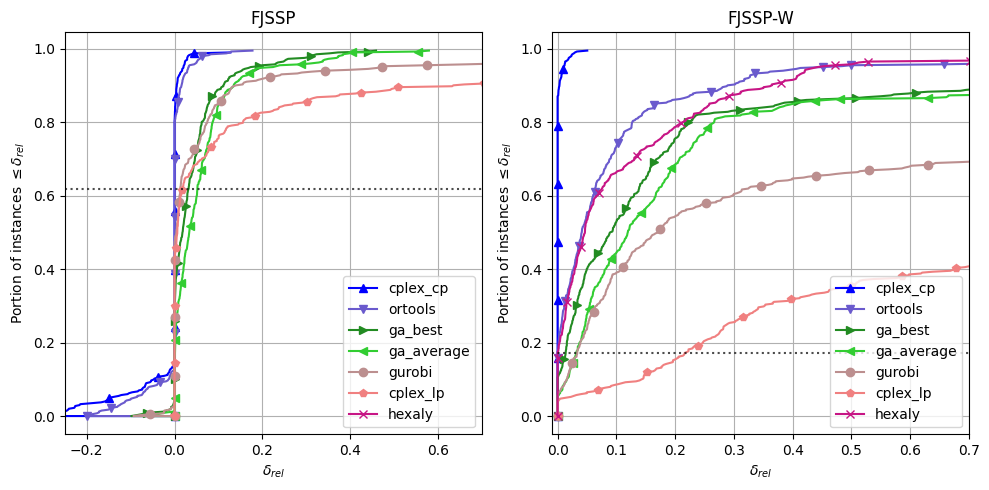

In [218]:
ecdf_inf(solver, instances=filtered_instances, n_instances=len(filtered_instances), labels=list(solver.keys()), colors=colors, hlines=[h_line_fjssp, h_line_fjssp_w], markers=markers, markerson=markerson, known_best_fjssp=True)

In [219]:
sub_selection = [
 'DPpaulli15.fjs',
 'Fattahi14.fjs',
 'Fattahi14.fjs',
 'DPpaulli15.fjs',
 'HurinkVdata49.fjs',
 'BrandimarteMk2.fjs',
 'DPpaulli18.fjs',
 'BrandimarteMk2.fjs',
 'Kacem3.fjs',
 'HurinkSdata35.fjs',
 'HurinkSdata50.fjs',
 'HurinkSdata50.fjs',
 'Behnke56.fjs',
 'Behnke56.fjs',
 'Fattahi18.fjs',
 'Behnke60.fjs',
 'Behnke55.fjs',
 'Behnke42.fjs',
 'HurinkSdata35.fjs',
 'HurinkSdata55.fjs',
 'HurinkSdata55.fjs',
 'Behnke60.fjs',
 'HurinkRdata54.fjs',
 'HurinkSdata1.fjs',
 'Behnke60.fjs',
 'BrandimarteMk8.fjs',
 'Behnke42.fjs',
 'Fattahi20.fjs',
 'Kacem4.fjs',
 'HurinkVdata30.fjs'
]
subset = []
for name in sub_selection:
    subset.append(change_name(name))

In [220]:
filtered_instances = subset

In [237]:
subset

['dppaulli15',
 'fattahi14',
 'fattahi14',
 'dppaulli15',
 'hurinkvdata49',
 'brandimarte2',
 'dppaulli18',
 'brandimarte2',
 'kacem3',
 'hurinksdata35',
 'hurinksdata50',
 'hurinksdata50',
 'behnke56',
 'behnke56',
 'fattahi18',
 'behnke60',
 'behnke55',
 'behnke42',
 'hurinksdata35',
 'hurinksdata55',
 'hurinksdata55',
 'behnke60',
 'hurinkrdata54',
 'hurinksdata1',
 'behnke60',
 'brandimarte8',
 'behnke42',
 'fattahi20',
 'kacem4',
 'hurinkvdata30']

In [238]:
subset_optimal_instances = {'no_worker': [], 'worker': []}
count = 0
for instance in subset:
    count += 1
    for s in solver:
        if instance in solver[s]['no_worker']:
            if solver[s]['no_worker'][instance]['status'] == 1 and instance not in subset_optimal_instances['no_worker']:
                subset_optimal_instances['no_worker'].append(instance)
        if instance in solver[s]['worker']:
            if solver[s]['worker'][instance]['status'] == 1 and instance not in subset_optimal_instances['worker']:
                subset_optimal_instances['worker'].append(instance)
h_line_fjssp = len(subset_optimal_instances['no_worker'])/len(subset)
h_line_fjssp_w = len(subset_optimal_instances['worker'])/len(subset)

In [239]:
count

30

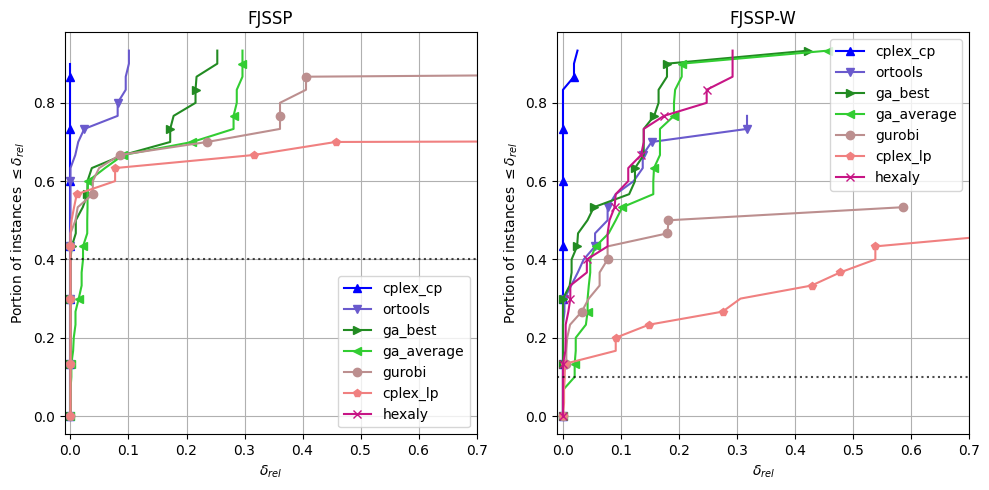

In [240]:
ecdf_inf(solver, instances=filtered_instances, n_instances=len(filtered_instances), labels=list(solver.keys()), colors=colors, hlines=[h_line_fjssp, h_line_fjssp_w], markers=markers, markerson=markerson)

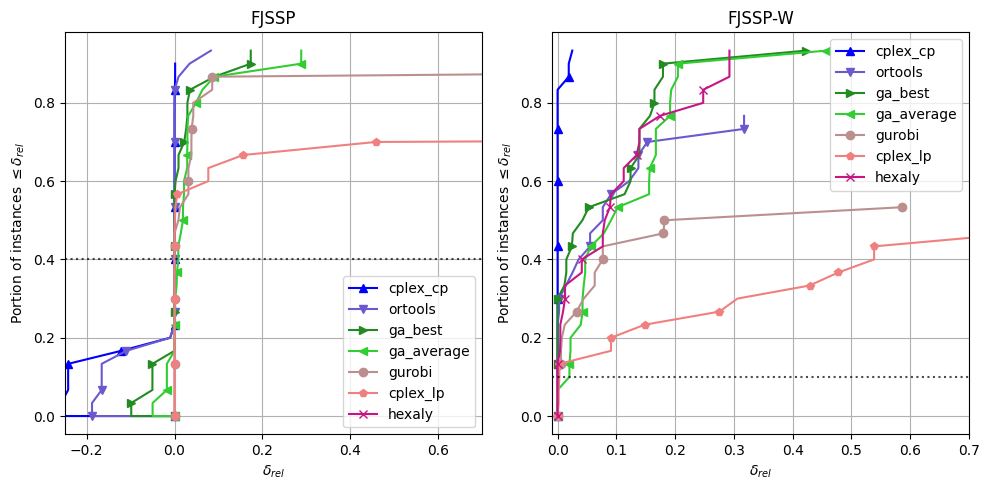

In [241]:
ecdf_inf(solver, instances=filtered_instances, n_instances=len(filtered_instances), labels=list(solver.keys()), colors=colors, hlines=[h_line_fjssp, h_line_fjssp_w], markers=markers, markerson=markerson, known_best_fjssp=True)

In [242]:
best_fjssp = dict()
best_fjssp_w = dict()
for instance in solver['ga_best']['worker']:
    best_fjssp[instance] = float('inf')
    best_fjssp_w[instance] = float('inf')
    for s in solver:
        if instance in solver[s]['no_worker']:
            if solver[s]['no_worker'][instance]['fitness'] < best_fjssp[instance]:
                best_fjssp[instance] = solver[s]['no_worker'][instance]['fitness']
        if instance in solver[s]['worker']:
            if solver[s]['worker'][instance]['fitness'] < best_fjssp_w[instance]:
                best_fjssp_w[instance] = solver[s]['worker'][instance]['fitness']
gaps = dict()
for s in solver:
    gaps[s] = {'worker': dict(), 'no_worker': dict()}


In [243]:
for instance in solver['ga_best']['worker']:
    for s in solver:
        if instance in solver[s]['no_worker']:
            gap_fjssp = calculate_value(solver[s]['no_worker'][instance]['fitness'], best_fjssp[instance])
        if instance in solver[s]['worker']:
            gap_fjssp_w = calculate_value(solver[s]['worker'][instance]['fitness'], best_fjssp_w[instance])
        gaps[s]['worker'][instance] = gap_fjssp_w
        gaps[s]['no_worker'][instance] = gap_fjssp


In [244]:
average_gaps = dict()
for s in solver:
    avg_fjssp = 0
    avg_fjssp_w = 0
    for instance in gaps[s]['worker']:
        avg_fjssp_w += gaps[s]['worker'][instance]
    for instance in gaps[s]['no_worker']:
        avg_fjssp += gaps[s]['no_worker'][instance]
    avg_fjssp_w /= len(gaps[s]['worker'])
    avg_fjssp /= len(gaps[s]['no_worker'])
    average_gaps[s] = {'fjssp': avg_fjssp, 'fjssp_w': avg_fjssp_w}


In [245]:
average_gaps # NOTE: gaps to found best, not literature

{'cplex_cp': {'fjssp': 0.0003705858278120309,
  'fjssp_w': 0.0015603166633439789},
 'ortools': {'fjssp': 0.010181545371274463, 'fjssp_w': 0.1004933365664816},
 'ga_best': {'fjssp': 0.0593015343618764, 'fjssp_w': 0.19453587387154017},
 'ga_average': {'fjssp': 0.07769714146825962, 'fjssp_w': 0.24504147978771956},
 'gurobi': {'fjssp': 0.24298665521475815, 'fjssp_w': 0.6738626646835943},
 'cplex_lp': {'fjssp': 0.6478248038521724, 'fjssp_w': 2.440564224165074},
 'hexaly': {'fjssp': 0.6478248038521724, 'fjssp_w': 0.15076061070957644}}